### import the used libraries

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, make_scorer, precision_score, recall_score, f1_score
import seaborn as sns
import math

### first i read the dataset and take a copy of it

In [32]:
df = pd.read_csv('loan_data.csv')
mod_df=df.copy()

In [3]:
mod_df

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


### transform the string categorical columns using label encoding to use for KNN

In [33]:

mod_df['person_gender'] = LabelEncoder().fit_transform(mod_df['person_gender'])
mod_df['loan_intent'] = LabelEncoder().fit_transform(mod_df['loan_intent'])
mod_df['person_home_ownership'] = LabelEncoder().fit_transform(mod_df['person_home_ownership'])
mod_df['person_education'] = LabelEncoder().fit_transform(mod_df['person_education'])
mod_df['previous_loan_defaults_on_file'] = LabelEncoder().fit_transform(mod_df['previous_loan_defaults_on_file'])


### define x as independent variables and y as output/label/target

In [34]:
X = mod_df.iloc[:, :-1].values
y = mod_df.iloc[:, -1].values

In [155]:
X

array([[ 22.,   0.,   4., ...,   3., 561.,   0.],
       [ 21.,   0.,   3., ...,   2., 504.,   1.],
       [ 25.,   0.,   3., ...,   3., 635.,   0.],
       ...,
       [ 33.,   1.,   0., ...,  10., 668.,   0.],
       [ 29.,   1.,   1., ...,   6., 604.,   0.],
       [ 24.,   1.,   3., ...,   3., 628.,   0.]])

### define the range of K from 1 to the sqrt of len of dataset, then make scorers directory which store accuracy, precision, recall and f1_score of each K, then scalling the data using min_max scaler

In [35]:
k_values = [i for i in range (1,int(math.sqrt(len(df)))+1)]
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted')
}

scaler = MinMaxScaler()
X = scaler.fit_transform(X)


### split data into 75% for train and 25% for test

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

### for each k i store its accuracy, precision, recall and f1_score and use cross validation to best k

In [37]:
results = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_validate(knn, X_train, y_train, cv=5,  scoring=scorers)
    results.append({
        'k': k,
        'accuracy': np.mean(scores['test_accuracy']),
        'precision': np.mean(scores['test_precision']),
        'recall': np.mean(scores['test_recall']),
        'f1_score': np.mean(scores['test_f1_score'])
    })

### make the results as dataframe with metrics corresponding to each K

In [38]:
results_df = pd.DataFrame(results)

print(results_df)

       k  accuracy  precision    recall  f1_score
0      1  0.871526   0.869834  0.871526  0.870572
1      2  0.875556   0.872473  0.875556  0.865108
2      3  0.884533   0.881677  0.884533  0.882663
3      4  0.886696   0.883190  0.886696  0.879843
4      5  0.889422   0.886128  0.889422  0.886996
..   ...       ...        ...       ...       ...
207  208  0.880830   0.875940  0.880830  0.875009
208  209  0.880978   0.876081  0.880978  0.875358
209  210  0.880770   0.875877  0.880770  0.874930
210  211  0.881067   0.876185  0.881067  0.875416
211  212  0.880711   0.875807  0.880711  0.874841

[212 rows x 5 columns]


### visualizes how the performance metrcis change as K varies, to help identify the best K for the model

c:\Users\Mega Store\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Mega Store\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Mega Store\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Mega Store\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

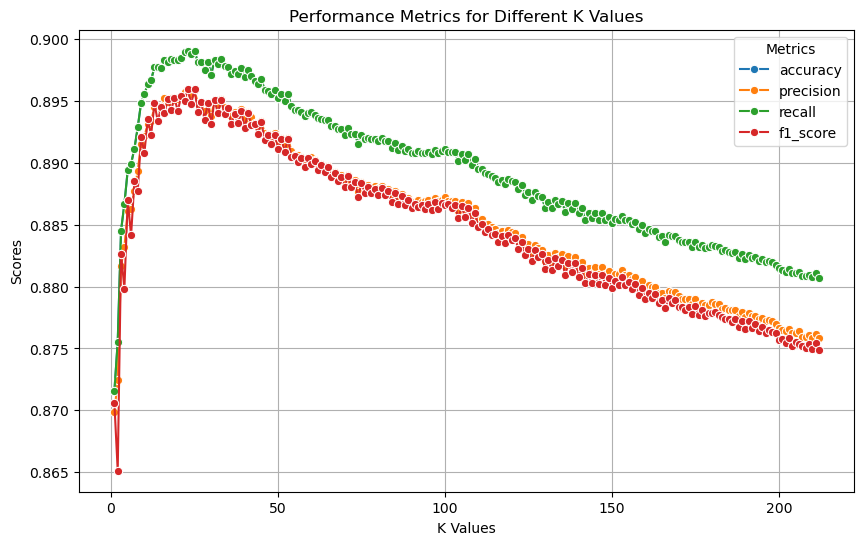

In [39]:
metrics = ['accuracy', 'precision', 'recall', 'f1_score']

plt.figure(figsize=(10, 6))  # Adjust the size of the figure

for metric in metrics:
    sns.lineplot(x=results_df['k'], y=results_df[metric], marker='o', label=metric)

# Customize the plot
plt.xlabel("K Values")
plt.ylabel("Scores")
plt.title("Performance Metrics for Different K Values")
plt.legend(title="Metrics")
plt.grid(True)
plt.show()


c:\Users\Mega Store\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Mega Store\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


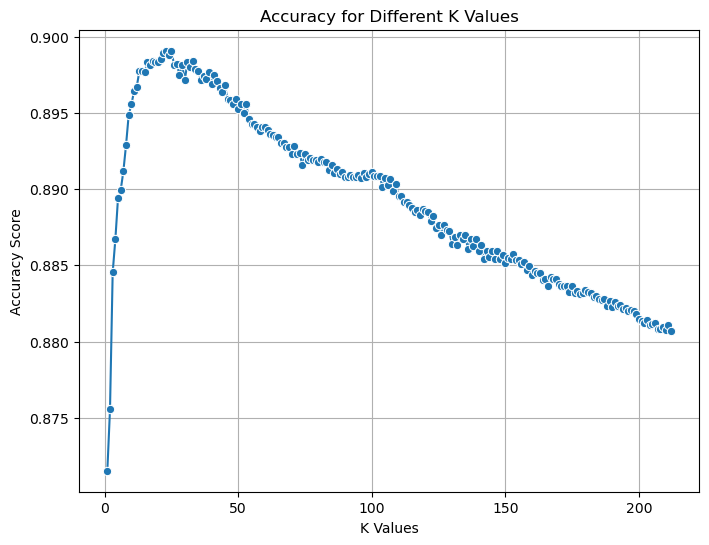

c:\Users\Mega Store\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Mega Store\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


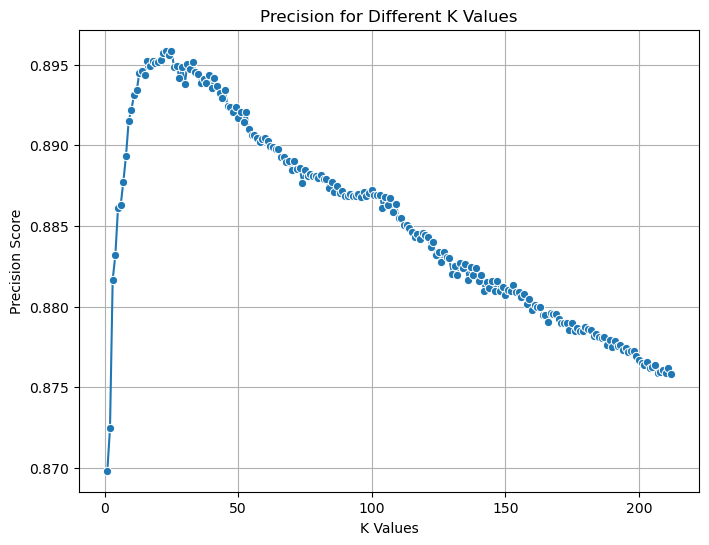

c:\Users\Mega Store\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Mega Store\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


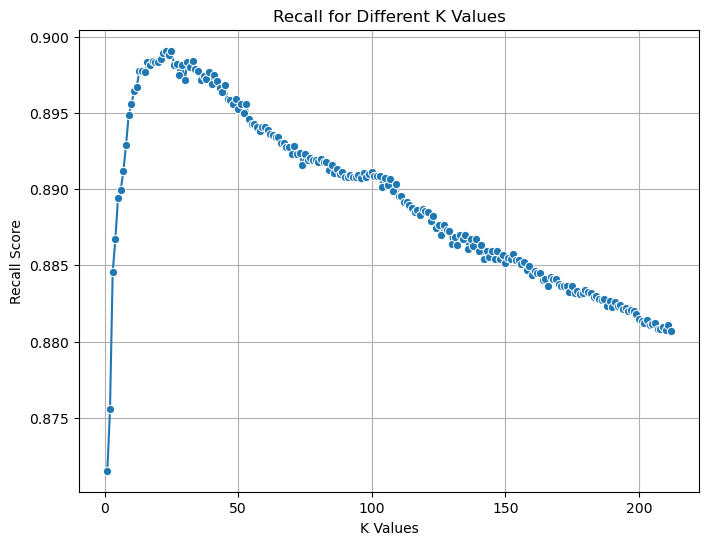

c:\Users\Mega Store\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Mega Store\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


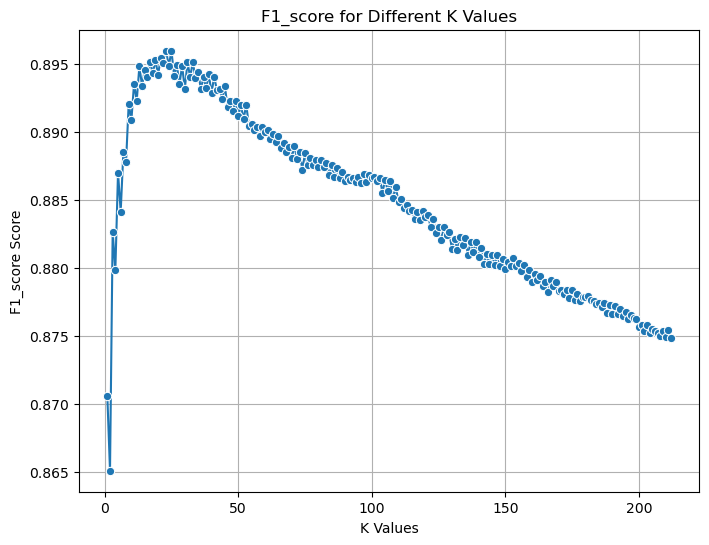

In [40]:
metrics = ['accuracy', 'precision', 'recall', 'f1_score']

for metric in metrics:
    plt.figure(figsize=(8, 6))  # Create a new figure for each plot
    sns.lineplot(x=results_df['k'], y=results_df[metric], marker='o')
    plt.xlabel("K Values")
    plt.ylabel(f"{metric.capitalize()} Score")
    plt.title(f"{metric.capitalize()} for Different K Values")
    plt.grid(True)
    plt.show()


### Check Data Balance

In [14]:
unique_classes, class_counts = np.unique(y, return_counts=True)

class_distribution = pd.DataFrame({
    'Class': unique_classes,
    'Count': class_counts,
    'Percentage': (class_counts / len(y)) * 100
})

print(class_distribution)

# Check imbalance threshold (e.g., <10% for any class is considered imbalanced)
threshold = 10  # 10% threshold
is_imbalanced = (class_distribution['Percentage'] < threshold).any()

if is_imbalanced:
    print("The dataset is imbalanced.")
else:
    print("The dataset is balanced.")

   Class  Count  Percentage
0      0  35000   77.777778
1      1  10000   22.222222
The dataset is balanced.


### By normalizing the metrics to the range zero and one, all metrics are brought to the same scale, allowing for a fair combination, The combined score is calculated as the average of the normalized metrics, representing an aggregate measure of performance.Finally, the code identifies the value of 𝑘 that maximizes this combined score

In [41]:
# Normalize metrics to the range [0, 1] for fair combination
results_df['normalized_accuracy'] = results_df['accuracy'] / results_df['accuracy'].max()
results_df['normalized_precision'] = results_df['precision'] / results_df['precision'].max()
results_df['normalized_recall'] = results_df['recall'] / results_df['recall'].max()
results_df['normalized_f1_score'] = results_df['f1_score'] / results_df['f1_score'].max()

# Calculate a combined score (average of normalized metrics)
results_df['combined_score'] = (
    results_df['normalized_accuracy'] +
    results_df['normalized_precision'] +
    results_df['normalized_recall'] +
    results_df['normalized_f1_score']
) / 4

# Find the k with the highest combined score
best_k = results_df.loc[results_df['combined_score'].idxmax(), 'k']

print(f"Best k value based on combined score: {best_k}")


Best k value based on combined score: 25


In [19]:
print(X_train)

[[0.0483871  1.         0.25       ... 0.03571429 0.55434783 1.        ]
 [0.0483871  0.         1.         ... 0.07142857 0.47826087 1.        ]
 [0.03225806 1.         0.         ... 0.03571429 0.39565217 1.        ]
 ...
 [0.07258065 0.         0.25       ... 0.25       0.61304348 0.        ]
 [0.05645161 1.         0.75       ... 0.17857143 0.34347826 0.        ]
 [0.02419355 1.         0.         ... 0.         0.55217391 1.        ]]


### use the best choosen k and try with metric minkowski with p=2 (euclidean distance) and train the model with the x_train and y_train

In [44]:
classifier = KNeighborsClassifier(n_neighbors = best_k, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=25)

### use the model to predict using the testing data, then print it and its coresponding actual y_test

In [45]:
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 1]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 1]
 [0 0]]


In [54]:
comparison = pd.DataFrame({
    'y_pred': y_pred,
    'y_test': y_test
})

print(comparison)

       y_pred  y_test
0           1       1
1           0       0
2           0       0
3           0       0
4           0       0
...       ...     ...
11245       0       1
11246       0       0
11247       0       0
11248       0       1
11249       0       0

[11250 rows x 2 columns]


### print the confusion matrix and other metric like accuracy, recall, precision and f1_score for evalution of KNN performance

In [46]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[8398  365]
 [ 750 1737]]


0.9008888888888889

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      8763
           1       0.83      0.70      0.76      2487

    accuracy                           0.90     11250
   macro avg       0.87      0.83      0.85     11250
weighted avg       0.90      0.90      0.90     11250



### make comparison between each matric distance and stud which will result into more good metrics like accuracy and recall and others, and after observing the results, manhatten and eclidean are slightly better than others distance as : Euclidean and Manhattan distances perform better when features are independent and not redundant. In high-dimensional data (e.g., many features), other metrics like Chebyshev or Minkowski can struggle because: The "curse of dimensionality" causes distances to become less meaningful. Manhattan distance is more robust in such cases because it sums individual feature differences, they perform better when the relationships between data points are linear or when the feature space is dense (no sparse or missing values)

In [52]:
metrics = ['euclidean', 'manhattan', 'minkowski', 'chebyshev', 'hamming', 'cosine']
metric_results = []

for metric in metrics:
    knn = KNeighborsClassifier(n_neighbors=best_k, metric=metric)  
    knn.fit(X_train, y_train)

    y_test_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')

    metric_results.append({'metric': metric, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1})


In [55]:
metric_comparison=pd.DataFrame(metric_results)
print(metric_comparison)

      metric  accuracy  precision    recall  f1_score
0  euclidean  0.900889   0.897752  0.900889  0.897797
1  manhattan  0.901956   0.898881  0.901956  0.898681
2  minkowski  0.900889   0.897752  0.900889  0.897797
3  chebyshev  0.895022   0.891435  0.895022  0.891594
4    hamming  0.849422   0.839870  0.849422  0.839144
